Load Dataset

In [1]:
from huggingface_hub import login

login("")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to /Users/andrejb/.cache/huggingface/token
Login successful


In [10]:
# import os
# import json
# from pathlib import Path
# import shutil
#
# # define paths
# base_path = Path("data")
# metadata_path = base_path.joinpath("key")
# image_path = base_path.joinpath("img")
# # define metadata list
# metadata_list = []
#
# # parse metadata
# for file_name in metadata_path.glob("*.json"):
#   with open(file_name, "r") as json_file:
#     # load json file
#     data = json.load(json_file)
#     # create "text" column with json string
#     text = json.dumps(data)
#     # add to metadata list if image exists
#     if image_path.joinpath(f"{file_name.stem}.jpg").is_file():
#       metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
#       # delete json file
#
# # write jsonline file
# with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
#     for entry in metadata_list:
#         json.dump(entry, outfile)
#         outfile.write('\n')
#
# # remove old meta data
# shutil.rmtree(metadata_path)

In [2]:
from datasets import load_dataset

dataset = load_dataset("katanaml-org/invoices-donut-data-v2", split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

# import os
# import json
# from pathlib import Path
# import shutil
# from datasets import load_dataset
#
# # define paths
# base_path = Path("data")
# metadata_path = base_path.joinpath("key")
# image_path = base_path.joinpath("img")
#
# # Load dataset
# dataset = load_dataset("imagefolder", data_dir=image_path, split="train")
#
# print(f"Dataset has {len(dataset)} images")
# print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/501 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/andrejb/.cache/huggingface/datasets/imagefolder/default-a38446cfb1709a17/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Dataset has 500 images
Dataset features are: dict_keys(['image', 'text'])


Random sample is 310
OCR text is {"header": {"invoice_no": "61356291", "invoice_date": "09/06/2012", "seller": "Chapman, Kim and Green 64731 James Branch Smithmouth, NC 26872", "client": "Rodriguez-Stevens 2280 Angela Plain Hortonshire, MS 93248", "seller_tax_id": "949-84-9105", "client_tax_id": "939-98-8477", "iban": "GB50ACIE59715038217063"}, "items": [{"item_desc": "Wine Glasses Goblets Pair Clear Glass", "item_qty": "5,00", "item_net_price": "12,00", "item_net_worth": "60,00", "item_vat": "10%", "item_gross_worth": "66,00"}, {"item_desc": "With Hooks Stemware Storage Multiple Uses Iron Wine Rack Hanging Glass", "item_qty": "4,00", "item_net_price": "28,08", "total_net_worth": "112,32", "item_vat": "10%", "item_gross_worth": "123,55"}, {"item_desc": "Replacement Corkscrew Parts Spiral Worm Wine Opener Bottle Houdini", "item_qty": "1,00", "item_net_price": "7,50", "total_net_worth": "7,50", "item_vat": "10%", "item_gross_worth": "8,25"}, {"item_desc": "HOME ESSENTIALS GRADIENT STEMLE

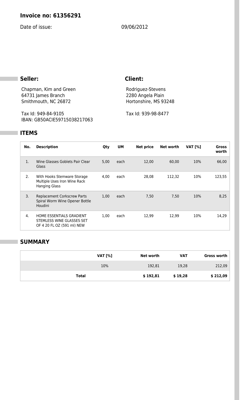

In [3]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))

In [4]:
# dataset.push_to_hub("katanaml-org/invoices-donut-data-v2", private=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Prepare dataset for Donut

In [13]:
import os
import json
from pathlib import Path
import shutil

new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")
#    Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
#    New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Sample: <s><s_summary><s_total_vat>$0,75</s_total_vat><s_total_net_worth>$7,50</s_total_net_worth><s_total_gross_worth>$8,25</s_total_gross_worth></s_summary><s_items><s_item_vat>10%</s_item_vat><s_item_qty>1,00</s_item_qty><s_item_net_worth>7,50</s_item_net_worth><s_item_net_price>7,50</s_item_net_price><s_item_gross_worth>8,25</s_item_gross_worth><s_item_desc>Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter</s_item_desc></s_items><s_header><s_seller_tax_id>958-74-3511</s_seller_tax_id><s_seller>Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228</s_seller><s_invoice_no>40378170</s_invoice_no><s_invoice_date>10/15/2012</s_invoice_date><s_iban>GB77WRBQ31965128414006</s_iban><s_client_tax_id>998-87-7723</s_client_tax_id><s_client>Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601</s_client></s_header></s>
New special tokens: ['<s_summary>', '</s_summary>', '<s_total_vat>', '</s_total_vat>', '<s_total_net_worth>', '</s_

In [14]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [960,1280] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/andrejb/infra/shared/katana-git/sparrow/sparrow-ml/venv/lib/python3.7/site-packages/transformers/models/donut/processing_donut.py:188: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  FutureWarning,


In [15]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [21]:
from datasets import load_from_disk
from transformers import DonutProcessor

# COMMENT IN in case you want to save the processed dataset to disk in case of error later
# processed_dataset.save_to_disk("processed_dataset")
# processor.save_pretrained("processor")

## COMMENT IN in case you want to load the processed dataset from disk in case of error later
# processed_dataset = load_from_disk("processed_dataset")
# processor = DonutProcessor.from_pretrained("processor")

In [22]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 450
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 50
    })
})


Fine-tune and evaluate Donut model

In [24]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
# model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.encoder.image_size = [1280, 960]
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

New embedding size: Embedding(57563, 1024)


In [26]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "invoices-donut-model-v2"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=1,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=False,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/katanaml/invoices-donut-model-v2 into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [27]:
# Start training
trainer.train()

/Users/andrejb/infra/shared/katana-git/sparrow/sparrow-ml/venv/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss


KeyboardInterrupt: 

In [ ]:
# Save processor and create model card
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()

In [ ]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np

# hidde logs
transformers.logging.disable_default_handler()


# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("invoices-donut-model-v2")
model = VisionEncoderDecoderModel.from_pretrained("invoices-donut-model-v2")

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 50)]

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))